In [ ]:
%cd ..

In [33]:
import numpy as np
import pandas as pd

from hft.utils import logger
logger.to_file = True
logger.fmt_string = "%(message)s"


from hft.backtesting import backtest
from hft.backtesting.output import StorageOutput
from hft.utils.consts import QuoteSides
from hft.backtesting.readers import OrderbookReader, TimeLimitedReader
from hft.backtesting.strategy import CalmStrategy
from hft.units.metrics.instant import VWAP_volume, HayashiYoshido, CraftyCorrelation
from hft.units.metrics.composite import Lipton
from hft.utils.data import OrderBook
from hft.units.filters import Filters
from hft.utils.types import DepleshionReplenishmentSide

import matplotlib.pyplot as plt
import matplotlib.lines as mlines
from tqdm import tqdm

from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

In [60]:
secs = 120
bucket_size = 5
lipton_levels=8
hym = HayashiYoshido(secs, False)
crafty = CraftyCorrelation(secs, bucket_size, 'crafty')
lipton= Lipton(hym.name, lipton_levels)
# lipton2= Lipton(crafty.name, lipton_levels)

In [61]:
hy_values = []
deltas = []
lipton_v = []
crafty_values = []

class MyOutput(StorageOutput):
    def consume(self, labels, ts, object):
      if 'hayashi-yoshido' == labels[0]: #  *list(hym._integral_sum[DepleshionReplenishmentSide.BID_ASK][labels[1]].values())
        hy_values.append((ts, labels[1], *object))
      elif 'crafty' == labels[0]:
        crafty_values.append((ts, labels[1], *object))
      elif 'delta' in labels and hym.filter(object):
        deltas.append((ts, object, labels[-1]))
      elif 'lipton' in labels: 
        if object is not None:
            lipton_v.append((ts, labels[-2], object))

In [62]:
reader = TimeLimitedReader(snapshot_file='tests/resources/huge_dataset/orderbook_10_03_20.csv.gz', skip_time='20 min', limit_time='40 min')

hy_values = []
simulation = CalmStrategy(filter=5, delta_metrics=[hym, crafty], composite_metrics=[lipton])
storage = MyOutput(instant_metric_names=[hym.name], time_metric_names=[])

backtester = backtest.Backtest(reader, simulation, storage)
backtester.run(tqdm_enabled=True)

Current time: 2020-03-10 19:17:36.892000: : 171774it [02:10, 1315.15it/s]                                                            
Current time: 2020-03-10 19:24:33.789000: : 44703it [00:43, 1020.23it/s]                                                             


In [63]:
hy = pd.DataFrame(hy_values, columns=['date', 'symbol', 'hy', 'dr-side'])
hy.index = pd.DatetimeIndex(pd.to_datetime(hy.date))
hy.tail()

,date,symbol,hy,dr-side
date,,,,
2020-03-10 19:25:10.882,2020-03-10 19:25:10.882,XBTUSD,0.186142,1
2020-03-10 19:25:10.884,2020-03-10 19:25:10.884,XBTUSD,0.186143,1
2020-03-10 19:25:10.889,2020-03-10 19:25:10.889,ETHUSD,0.636551,2
2020-03-10 19:25:10.899,2020-03-10 19:25:10.899,XBTUSD,0.186143,1
2020-03-10 19:25:10.900,2020-03-10 19:25:10.900,XBTUSD,0.186144,1


In [64]:
craft = pd.DataFrame(crafty_values, columns=['date', 'symbol', 'corr_', 'dr-side'])
craft.index = pd.DatetimeIndex(pd.to_datetime(craft.date))
craft.dropna(inplace=True)
craft.tail()

,date,symbol,corr_,dr-side
date,,,,
2020-03-10 19:25:10.882,2020-03-10 19:25:10.882,XBTUSD,-0.047170,1
2020-03-10 19:25:10.884,2020-03-10 19:25:10.884,XBTUSD,-0.047170,1
2020-03-10 19:25:10.889,2020-03-10 19:25:10.889,ETHUSD,0.211132,2
2020-03-10 19:25:10.899,2020-03-10 19:25:10.899,XBTUSD,-0.047170,1
2020-03-10 19:25:10.900,2020-03-10 19:25:10.900,XBTUSD,-0.047170,1


In [72]:
# # df_deltas = pd.DataFrame(deltas, columns=['date', ''])
ts, dlts, lbl = zip(*deltas)
dlts = list(map(lambda x: np.sum(x.diff[1, :]), dlts))
dlt_df = pd.DataFrame(zip(ts, dlts, lbl), columns=['date', 'delta', 'label'])
dlt_df.index = pd.DatetimeIndex(pd.to_datetime(dlt_df.date))
dlt_df.head()

,date,delta,label
date,,,
2020-03-10 18:45:11.118,2020-03-10 18:45:11.118,1500.0,ETHUSD
2020-03-10 18:45:11.124,2020-03-10 18:45:11.124,-9400.0,ETHUSD
2020-03-10 18:45:11.131,2020-03-10 18:45:11.131,-900.0,ETHUSD
2020-03-10 18:45:11.261,2020-03-10 18:45:11.261,20000.0,ETHUSD
2020-03-10 18:45:11.322,2020-03-10 18:45:11.322,2000.0,ETHUSD


In [66]:
lipton_df = pd.DataFrame(lipton_v, columns=['date', 'label', 'prob'])
lipton_df.index = pd.DatetimeIndex(pd.to_datetime(lipton_df.date))
lipton_df.tail()

,date,label,prob
date,,,
2020-03-10 19:25:10.882,2020-03-10 19:25:10.882,XBTUSD,0.894153
2020-03-10 19:25:10.884,2020-03-10 19:25:10.884,XBTUSD,0.894154
2020-03-10 19:25:10.889,2020-03-10 19:25:10.889,ETHUSD,0.348043
2020-03-10 19:25:10.899,2020-03-10 19:25:10.899,XBTUSD,0.889297
2020-03-10 19:25:10.900,2020-03-10 19:25:10.900,XBTUSD,0.889297


In [67]:
snapshots = reader._snapshots_df
snapshots = snapshots[[2, 3, 13, 23, 33]]
snapshots.columns = ['symbol', 'ask_price', 'ask_volume', 'bid_price', 'bid_volume']
snapshots.tail()

,symbol,ask_price,ask_volume,bid_price,bid_volume
0,,,,,
2020-03-10 19:25:10.894,XBTUSD,7912.50,260826,7912.0,1379936
2020-03-10 19:25:10.899,XBTUSD,7912.50,260951,7912.0,1379936
2020-03-10 19:25:10.900,XBTUSD,7912.50,261117,7912.0,1379936
2020-03-10 19:25:10.915,XBTUSD,7912.50,261117,7912.0,1379936
2020-03-10 19:25:10.954,ETHUSD,200.75,38235,200.7,55552


In [68]:
symbol = 'XBTUSD'

xbt_snap = snapshots[snapshots.symbol == symbol]
xbt_hy = hy[hy.symbol == symbol]
# xbt_delta = dlt_df[dlt_df.label == symbol]
xbt_lipton = lipton_df[lipton_df.label == symbol]
xbt_craft = craft[craft.symbol == symbol]

In [30]:
# hy_copy = xbt_hy.copy() 

In [43]:
hy_diff = (hy_copy.hy - xbt_hy.hy)

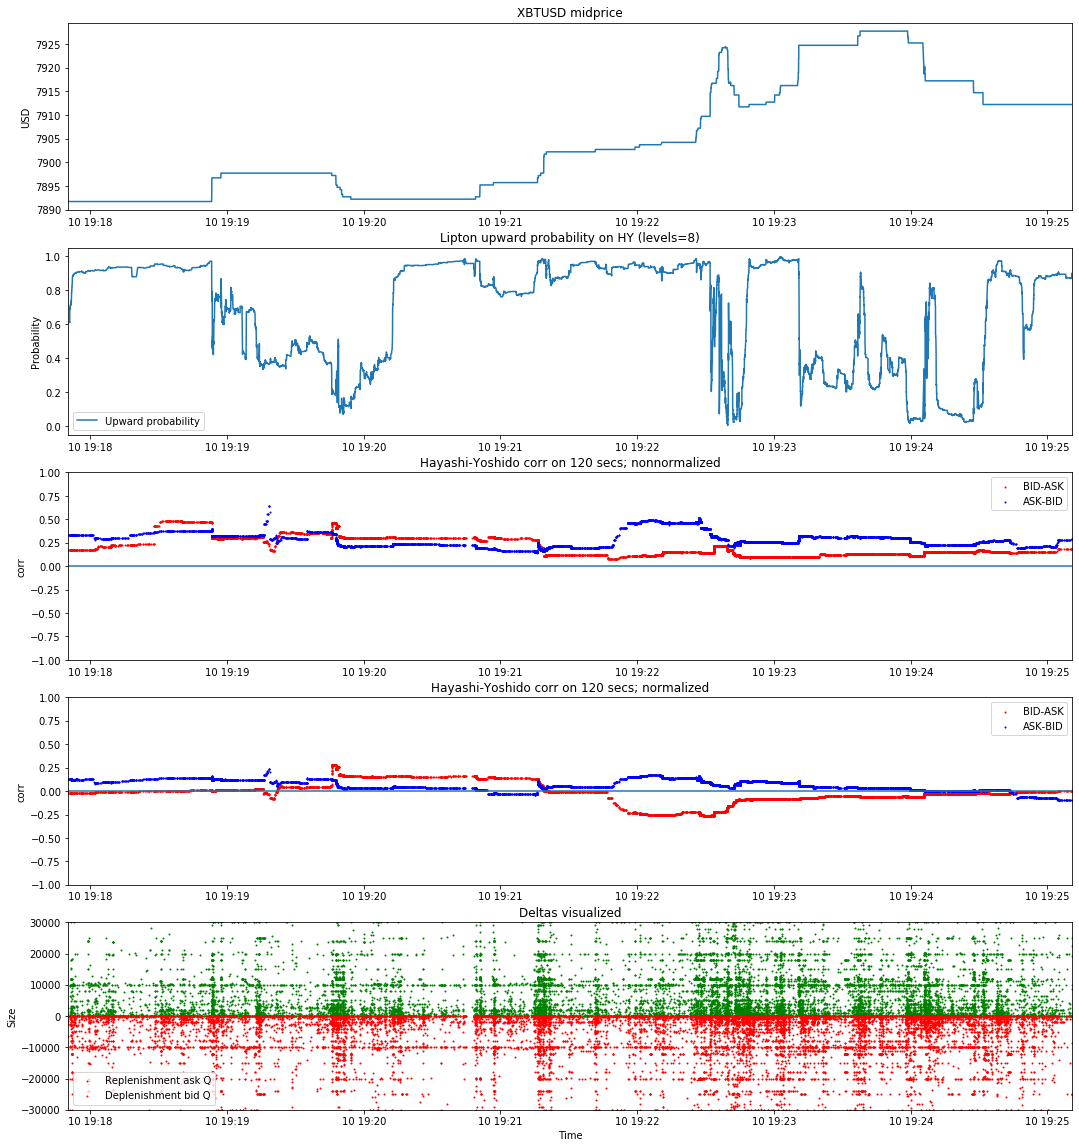

In [74]:
f = plt.figure(figsize=(18, 20))
prices = f.add_subplot(511)
prob = f.add_subplot(512)
vol = f.add_subplot(513)
vol2 = f.add_subplot(514)
# _craft = f.add_subplot(414)
bars = f.add_subplot(515)

_min = xbt_snap.index.min()
_max = xbt_snap.index.max()

prices.plot(xbt_snap.index, (xbt_snap.ask_price + xbt_snap.bid_price) / 2, label='prices')
prices.set(title=f'{symbol} midprice', ylabel='USD')
prices.set_xlim([_min, _max])


prob.plot(xbt_lipton.date, xbt_lipton['prob'], label='Upward probability')
prob.set_xlim([_min, _max])
prob.set(title=f'Lipton upward probability on HY (levels={lipton_levels})', ylabel='Probability')

prob.legend()


for s, c, l in zip([1, 2], ['r','b'], ['BID-ASK', 'ASK-BID']):
    _hy = hy_copy[hy_copy['dr-side'] == s]
    vol2.scatter(_hy.date, _hy.hy, s=1, color=c, label=l)
    vol2.set_xlim([_min, _max])
    vol2.set_ylim([-1.0, 1.0])

vol2.set(title=f'Hayashi-Yoshido corr on {secs} secs; normalized', ylabel='corr')
vol2.plot([_min, _max], [0, 0])
vol2.legend()


for s, c, l in zip([1, 2], ['r','b'], ['BID-ASK', 'ASK-BID']):
    _hy = xbt_hy[xbt_hy['dr-side'] == s]
    vol.scatter(_hy.date, _hy.hy, s=1, color=c, label=l)
    vol.set_xlim([_min, _max])
    vol.set_ylim([-1.0, 1.0])

vol.set(title=f'Hayashi-Yoshido corr on {secs} secs; nonnormalized', ylabel='corr')
vol.plot([_min, _max], [0, 0])
vol.legend()


# for s, c, l in zip([1, 2], ['r','b'], ['BID-ASK', 'ASK-BID']):
#     cr = xbt_craft[xbt_craft['dr-side'] == s]
#     _craft.scatter(cr.date, cr.corr_, s=1, color=c, label=l)
#     _craft.set_xlim([_min, _max])
#     _craft.set_ylim([-1.0, 1.0])

# _craft.set(title=f'Crafty correlation on {secs} secs, bucket-size={bucket_size}', ylabel='corr')
# _craft.plot([_min, _max], [0, 0])
# _craft.legend()


bars.scatter(dlt_df[dlt_df.delta > 0].date, dlt_df[dlt_df.delta > 0].delta, color='g', s=1, label='Replenishment ask Q')
bars.scatter(dlt_df[dlt_df.delta < 0].date, dlt_df[dlt_df.delta < 0].delta, color='r', s=1, label='Deplenishment bid Q')
bars.set_xlim([_min, _max])
bars.set_ylim([-30000, 30000])
bars.set(title='Deltas visualized', xlabel='Time', ylabel='Size')
bars.legend()

plt.show()

In [ ]:
hym._integral_sum